In [324]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce
from datetime import datetime
from pandas.plotting import lag_plot
%matplotlib inline
df2=pd.read_csv("/content/KVK_Field_sensor1 modified - Soda.csv",parse_dates=['Date Time'])
df2.drop(['Wind direction','Snowfall','Snow depth','Short-wave irradiation'],axis='columns',inplace=True)
temp=df2[['Temperature']]
rel=df2[['Relative Humidity']]
pres=df2[['Pressure']]
wind=df2[['Wind speed']]
rain=df2[['Rainfall']]
df=pd.read_csv("/content/KVK_ORG1.xlsx - feeds.csv",parse_dates=['created_at'])
df['created_at'] = df.created_at.dt.strftime('%Y-%m-%d %H:%M:%S')
df1=df.drop(['Air Temperature (degree Centigrate)','entry_id','Relative Air Humidity (%)','Soil moisture (Resistance-Ohm)'],axis='columns')
merged1=pd.concat([df1,temp,rel,pres,wind,rain],axis='columns')
soil=merged1[['Soil moisture (Centi Bar)']]
merged2=pd.concat([dfl,soil],axis='columns')
merged1.rename(columns = {'created_at':'Date Time'}, inplace = True)
veg=pd.read_csv("/content/Vegetation indices.xlsx - ee-chart.csv",parse_dates=['Vegitation Index'])
veg.drop(0,axis='rows',inplace=True)
veg.rename(columns = {'Vegitation Index':'Date_Time'}, inplace = True)
veg.drop(['NDWI1','CAI','EVI','GNDVI','SAVI','MSI','ARI','DWSI','CVI'], axis = 1,inplace=True)
veg.dropna(inplace=True)
veg.rename(columns = {'Date_Time':'Date Time'}, inplace = True)
merged1['Soil moisture (Centi Bar)'].fillna('0',inplace=True)
merged1['Temperature'].fillna('0',inplace=True)
merged1['Relative Humidity'].fillna('0',inplace=True)
merged1['Pressure'].fillna('0',inplace=True)
merged1['Wind speed'].fillna('0',inplace=True)
merged1['Rainfall'].fillna('0',inplace=True)
merged1.dropna(inplace=True)
merged2.dropna(inplace=True)
merged2_=merged2[['Date Time','Soil moisture (Centi Bar)','Temperature','Relative Humidity','Pressure','Wind speed','Rainfall']]
merged1['Date Time'] = pd.to_datetime(merged1['Date Time'])
merged2['Date Time'] = pd.to_datetime(merged2['Date Time'])
final=pd.merge_asof(merged1,merged2_.sort_values(['Date Time','Temperature'],),left_on='Date Time',right_on='Date Time')
final['TEMPERATURE']= final[['Temperature_y','Temperature_x']].median(axis='columns',skipna=True)
final.drop(['Temperature_y','Temperature_x'],axis='columns',inplace=True)
final['RELATIVE_HUMIDITY']= final[['Relative Humidity_x','Relative Humidity_y']].median(axis='columns',skipna=True)
final.drop(['Relative Humidity_x','Relative Humidity_y'],axis='columns',inplace=True)
final['SOIL_MOISTURE']= final[['Soil moisture (Centi Bar)_x','Soil moisture (Centi Bar)_y']].median(axis='columns',skipna=True)
final.drop(['Soil moisture (Centi Bar)_x','Soil moisture (Centi Bar)_y'],axis='columns',inplace=True)
final['PRESSURE']= final[['Pressure_x','Pressure_y']].median(axis='columns',skipna=True)
final.drop(['Pressure_x','Pressure_y'],axis='columns',inplace=True)
final['WIND_SPEED']= final[['Wind speed_x','Wind speed_y']].median(axis='columns',skipna=True)
final.drop(['Wind speed_x','Wind speed_y'],axis='columns',inplace=True)
final['RAINFALL']= final[['Rainfall_x','Rainfall_y']].median(axis='columns',skipna=True)
final.drop(['Rainfall_x','Rainfall_y'],axis='columns',inplace=True)
final_ds=pd.merge_asof(final,veg.sort_values(['Date Time'],),left_on='Date Time',right_on='Date Time')
final_ds.dropna(inplace=True)
final_ds

,Date Time,TEMPERATURE,RELATIVE_HUMIDITY,SOIL_MOISTURE,PRESSURE,WIND_SPEED,RAINFALL,NDVI
0,2022-01-25 20:29:44,283.110,63.550,25.970,986.600,1.845,0.009843,0.232
1,2022-01-25 20:30:02,283.215,62.870,25.960,986.950,1.725,0.009843,0.232
2,2022-01-25 20:30:19,283.600,61.885,25.960,987.310,1.665,0.009843,0.232
3,2022-01-25 20:30:37,284.800,60.290,25.960,987.760,1.825,0.009843,0.232
4,2022-01-25 20:30:55,286.080,55.540,25.960,988.160,2.090,0.009843,0.232
...,...,...,...,...,...,...,...,...
200172,2022-03-16 12:40:28,145.720,18.970,8.935,492.415,1.435,0.000000,0.363
200173,2022-03-16 12:40:46,145.720,18.970,8.935,492.415,1.435,0.000000,0.363
200174,2022-03-16 12:41:04,145.720,18.970,8.935,492.415,1.435,0.000000,0.363
200175,2022-03-16 12:41:21,145.720,18.970,8.935,492.415,1.435,0.000000,0.363


In [325]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from tqdm import tqdm_notebook
from itertools import product
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [326]:
print(final_ds.shape)
final_ds.head()

(200177, 8)


,Date Time,TEMPERATURE,RELATIVE_HUMIDITY,SOIL_MOISTURE,PRESSURE,WIND_SPEED,RAINFALL,NDVI
0,2022-01-25 20:29:44,283.110,63.550,25.97,986.60,1.845,0.009843,0.232
1,2022-01-25 20:30:02,283.215,62.870,25.96,986.95,1.725,0.009843,0.232
2,2022-01-25 20:30:19,283.600,61.885,25.96,987.31,1.665,0.009843,0.232
3,2022-01-25 20:30:37,284.800,60.290,25.96,987.76,1.825,0.009843,0.232
4,2022-01-25 20:30:55,286.080,55.540,25.96,988.16,2.090,0.009843,0.232


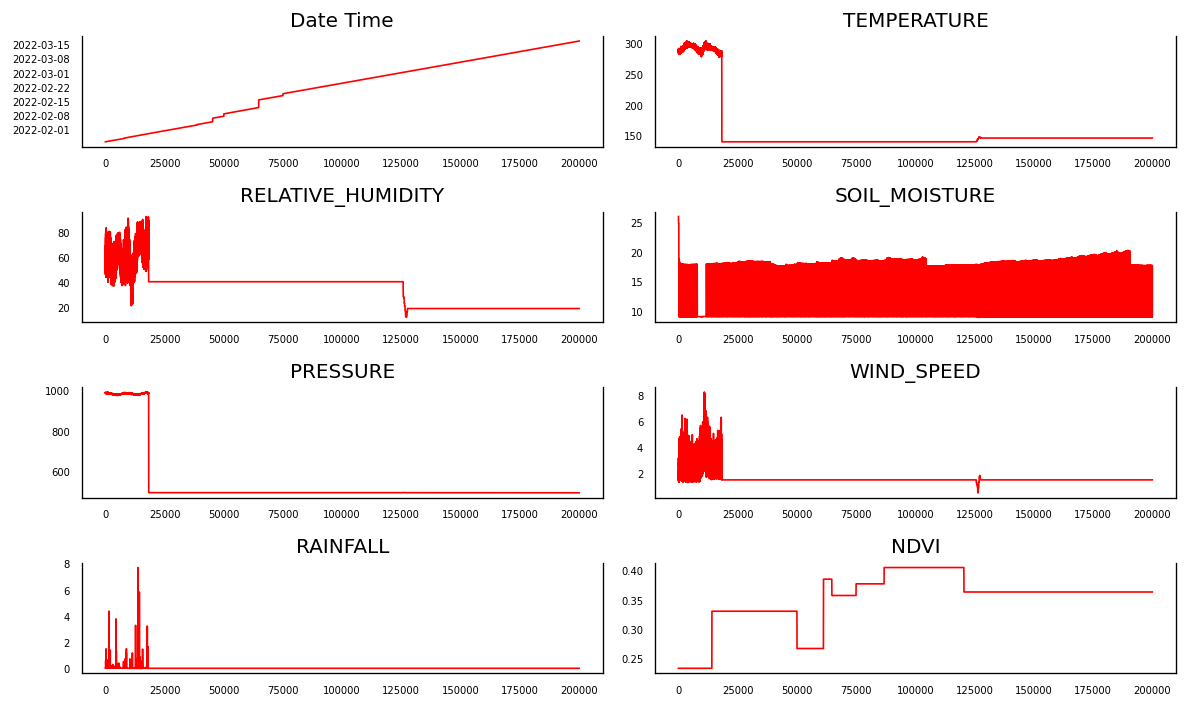

In [327]:
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = final_ds[final_ds.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    ax.set_title(final_ds.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)
plt.tight_layout();

In [328]:
ad_fuller_result_1 = adfuller(final_ds['TEMPERATURE'].diff()[1:])
print('realtemperature')
print(f'ADF Statistic: {ad_fuller_result_1[0]}')
print(f'p-value: {ad_fuller_result_1[1]}')
print('\n---------------------\n')
ad_fuller_result_2 = adfuller(final_ds['SOIL_MOISTURE'].diff()[1:])
print('real_soil_moisture')
print(f'ADF Statistic: {ad_fuller_result_2[0]}')
print(f'p-value: {ad_fuller_result_2[1]}')
ad_fuller_result_2 = adfuller(final_ds['RELATIVE_HUMIDFITY'].diff()[1:])
print('real_relative_humidity')
print(f'ADF Statistic: {ad_fuller_result_3[0]}')
print(f'p-value: {ad_fuller_result_3[1]}')
ad_fuller_result_2 = adfuller(final_ds['PRESSURE'].diff()[1:])
print('real_pressure')
print(f'ADF Statistic: {ad_fuller_result_4[0]}')
print(f'p-value: {ad_fuller_result_4[1]}')
ad_fuller_result_2 = adfuller(final_ds['WINDSPEED'].diff()[1:])
print('real_windspeed')
print(f'ADF Statistic: {ad_fuller_result_5[0]}')
print(f'p-value: {ad_fuller_result_5[1]}')
ad_fuller_result_2 = adfuller(final_ds['RAINFALL'].diff()[1:])
print('real_rainfall')
print(f'ADF Statistic: {ad_fuller_result_6[0]}')
print(f'p-value: {ad_fuller_result_6[1]}')

realgdp
ADF Statistic: -50.040095855351744
p-value: 0.0

---------------------

realcons
ADF Statistic: -68.59342973989023
p-value: 0.0


In [ ]:
print('temperature causes soil_humidity?\n')
print('------------------')
granger_1 = grangercausalitytests(final_ds[['TEMPERATURE', 'SOIL_MOISTURE']], 4)

print('\soilk_moisture causes temperature?\n')
print('------------------')
granger_2 = grangercausalitytests(final_ds[['SOIL_MOISTURE', 'TEMPERATURE']], 4)

In [ ]:
final_ds=final_ds[['TEMPERATURE','RELATIVE_HUMIDITY','SOIL_MOISTURE','PRESSURE','WIND_SPEED','RAINFALL','NDVI']]
print(final_ds.shape)

In [ ]:
train_df=final_ds[:-160142]
test_df=final_ds[-40035:]
model = VAR(train_df.diff()[1:])
sorted_order=model.select_order(maxlags=20)
print(sorted_order.summary())
var_model = VARMAX(train_df, order=(4,0),enforce_stationarity= True)
fitted_model = var_model.fit(disp=False)
print(fitted_model.summary())
n_forecast = 12
predict = fitted_model.get_prediction(start=len(train_df),end=len(train_df) + n_forecast-1)
predictions=predict.predicted_mean

In [ ]:
predictions.columns=['temperature_predicted','relative_humidity_predicted','soil_moisture_predicted','pressure_predicted','wind_speed_predicted',,'rainfall_predicted',,'ndvi_predicted']

In [ ]:
test_vs_pred=pd.concat([test_df,predictions],axis=1)
test_vs_pred.plot(figsize=(12,5))